## Step 0. Folder Structure
```
3. Deep Learning Project/
├── dataset_split/
│   ├── train/
│   │   ├── african_elephant (780 images)
│   │   ├── airliner (780 images)
│   │   └── ... (8 more folders)
│   ├── val/
│   │   ├── african_elephant (260 images)
│   │   ├── airliner (260 images)
│   │   └── ... (8 more folders)
│   └── test (2600 images)
├── data_preprocessed/
│   ├── labels_train.pt
│   ├── labels_val.pt
│   ├── tensor_test.pt
│   ├── tensor_train.pt
│   └── tensor_val.pt
├── models/
│   ├── resnet18_checkpoint.pkl
│   └── resnet34_checkpoint.pkl
├── src/
│   └── part3.ipynb
├── src_datasplit/
│   └── data_split.ipynb
├── MSA.yaml
├── README.md
└── IEEE_Report_Template.docx
```


In [58]:
!pip install opencv-python


^C


In [ ]:
!pip install torchvision

   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   - -------------------------------------- 0.1/1.7 MB 2.7 MB/s eta 0:00:01
   ---------- ----------------------------- 0.5/1.7 MB 7.3 MB/s eta 0:00:01
   ---------------------------- ----------- 1.2/1.7 MB 9.5 MB/s eta 0:00:01
   ---------------------------------------  1.7/1.7 MB 10.8 MB/s eta 0:00:01
   ---------------------------------------- 1.7/1.7 MB 9.9 MB/s eta 0:00:00


In [ ]:
# TODO: Import the libraries.
from typing import Tuple, List
import os
import cv2
from tqdm import tqdm
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
import copy
import matplotlib.pyplot as plt
import csv

## Step 1 Preprocessing
1. Load images and labels from folders into lists.
2. Resize the images.
3. Convert the image data type as float32 and limit the range in [0, 1].
4. Convert data from NHWC to NCHW and creat a PyTorch tensor from it.
5. Per-channel standardization of the dataset using training set statistics (mean and std computed independently for each color channel).
6. Saving the pre-processed sets as .pt files in the correct directory.
7. Load the pre-processed sets from .pt files. 

In [ ]:
# TODO: 1. Load images from folder into a list.
def image_loader(set_dir: str) -> Tuple[List[np.ndarray], List[str]]:
    # function inputs directory string, and load images into memory
    """
    Load all images from a dataset directory (train/val/test) into memory.
    Make sure:
        1. Load training and validation set images and labels in the correct order.
        2. Load testing set images in filename order (e.g., 0.jpg, 1.jpg, ...).
    
    Parameters:
    -----------
    set_dir : str
        Path to the directory containing either:
        - Class subdirectories (for train/val sets)
        - Direct image files (for test set)
        
    Returns:
    --------
    Tuple[List[np.ndarray], List[str]]
        images: List of BGR images (HWC format, uint8 dtype)
        labels: List of string labels (empty for test set)
        
    Example:
    --------
    >>> images_train, labels_train = image_loader("../dataset_split/train")
    >>> images_test, _ = image_loader("../dataset_split/test")
    """

    # store image and labels in these lists
    images = []
    labels = []

    # check if its test set (folder with images only, no separated class folders)
    is_test_set = all(file_name.lower().endswith(('.jpg')) # looking at 'every' files that ends with `.jpg` (in lower case)
                      for file_name in os.listdir(set_dir)) # looking at the files inside the directory
    # code above is basically a boolean. Checking if the files inside the folder is all '.jpg'. If not, go to else (where we assume is train and validation folder)

    if is_test_set:
        image_files = sorted( # sort the files in order
            os.listdir(set_dir), # listing all files in test folder
            key=lambda x: int(os.path.splitext(x)[0]) # create temporary function lambda for: splitext > only keeping the numeral part of every file name (deleting .jpg ext)
        )                                             # to prevent '10' coming before '2' due to alphanumeral strings.

        for file_name in image_files: # go through every file name from directory AND class
            img_path = os.path.join(set_dir, file_name) # join folder path with image name, to create full path
            img = cv2.imread(img_path) # using 'cv2' to load image into BGR format
            if img is not None: # check if any images are unreadable
                images.append(img) # append images into image list
            else:
                print(f"Warning: failed to load {img_path}")

    else:
        class_names = sorted(os.listdir(set_dir)) # label order sorted for consistency

        for class_name in class_names: # going through every folder name
            class_dir = os.path.join(set_dir, class_name) # concatenate directory folder name, with class folder name
            image_files = sorted(os.listdir(class_dir), # lists all the image file names from class folder. Once gathered, it's sorted in order for consistency
                                 key=lambda x: int(os.path.splitext(x)[0])
                                 )
            
            for file_name in image_files:
                img_path = os.path.join(class_dir, file_name)
                img = cv2.imread(img_path)
                if img is not None: # check if any images are unreadable
                    images.append(img)
                    labels.append(class_name) # append the class name into the labels list
                else:
                    print(f"Warning: failed to load {img_path}")

    return images, labels

In [ ]:
# TODO: 2. Resize images.
def img_resize(images: List[np.ndarray], target_size: int = 224) -> np.ndarray:
    """
    Resize images with the shortest edge to target_size and perform center cropping to square dimensions.
    
    Args:
        images: List of input images in BGR format (OpenCV default) with shape (H, W, C)
        target_size: Desired output size (both width and height after cropping). Default 224.
        
    Returns:
        Stacked numpy array of processed images with shape (N, target_size, target_size, 3)
        where N is the number of input images
        
    Raises:
        ValueError: If input images have inconsistent channels or invalid dimensions
        
    Notes:
        - Preserves original aspect ratio during resizing
        - Performs center cropping to exact square dimensions
        - Maintains uint8 dtype unless conversion forces float32
        
    Example:
        >>> imgs = [cv2.imread('test.jpg')]  # List of BGR images
        >>> processed = img_resize(imgs)
        >>> processed.shape  # (1, 224, 224, 3)
    """
    if not images:
        return np.array([])

    processed_images = []
    
    for img in images:
        if img.ndim != 3 or img.shape[2] != 3: # checking if image is in right dimensions: (height, width, colour channels), and [2] index check if colour channel = 3
            raise ValueError('Each image must have 3 channels (H,W,C).')

        h, w, c = img.shape # put all 3 dims into own variable
        # Rescaling: where the shortest side of image = 224, and the longer side will be scaled down to match the amount, scaled for the shorter side to keep image size
        import math
        if w > h:
            new_h = target_size
            new_w = math.ceil(w*(target_size/h)) # keep scaled image to integer, rather than float. Will cause issues when trying to use a half a pixel
        else:
            new_w = target_size
            new_h = math.ceil(h*(target_size/w)) # math.ceil helps round up, and avoid numbers going smaller than 224

        resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA) # resizing the image, based on the new preprocessed scale, where shortest side = 224 pixels
                                                                                # cv2.INTER_AREA > downsampling image, keeps best quality of the picture
        # Find the bounds of where to cut image from the centre. So it'll be target_size x target_size. (Using division rounding, only keeping whole number value so we can crop image with the integer)
        start_x = (new_w - target_size) // 2 # (224 - 224) // 2 = 0
        start_y = (new_h - target_size) // 2 # (334 - 224) // 2 = 55

        if new_w < target_size or new_h < target_size:
            raise ValueError(f"Resized image is too small for cropping: got ({new_h}, {new_w})")

        # selects image from the centre region of it's size
        cropped = resized[start_y:start_y + target_size, start_x:start_x + target_size] # if y = 0, then 0:0+224   if x = 55, then 55:55+224

        if cropped.shape != (target_size, target_size, 3): # checking that the shape of image should be (224,224,3)
            raise ValueError(f'Cropped image has the wrong shape: {cropped.shape}')
        
        processed_images.append(cropped) # adding preprocessed image to our list, so should look like (integer_location, target_size, target_size, colour_channels)

    return np.stack(processed_images)
    

In [ ]:
# Load images

images_train, labels_train = image_loader("../dataset_split/train")
images_val, labels_val = image_loader("../dataset_split/val")
images_test, _ = image_loader("../dataset_split/test")

In [ ]:
# Resize the images

images_train = img_resize(images_train, 224)
images_val = img_resize(images_val, 224)
images_test = img_resize(images_test, 224)

In [ ]:
# TODO: 3. Convert the image data type as float32 and limit the range in [0, 1].

images_train = (images_train/255.0).astype(np.float32) # image values only range from 0 to 255. So dividing by 255 will keep between 0 to 255
images_val = (images_val/255.0).astype(np.float32)
images_test = (images_test/255.0).astype(np.float32)

In [ ]:
# TODO: 4. Convert data from NHWC to NCHW and creat a PyTorch tensor from it.

# aka, reorganize the orientation of the processed shape from img_resize: (1, 224, 224, 3) to (1, 3, 224, 224)
tensor_train = torch.tensor(np.transpose(images_train, (0,3,1,2))).float()
tensor_val = torch.tensor(np.transpose(images_val, (0,3,1,2))).float()
tensor_test = torch.tensor(np.transpose(images_test, (0,3,1,2))).float()

In [ ]:
# TODO: 5. Per-channel standardization of the dataset using training set statistics (mean and std computed independently for each color channel).

# we have shape (1, 3, 224, 224) > but want to compute mean/std on N, H, W, not C. Since we want it computed for each colour channel. Making our shape (1, 3, 1, 1)
train_mean = tensor_train.mean(axis=(0,2,3), keepdims=True) # find mean for the values in int 0, 2, and 3
                                                            # keepdims=True, allows the operation performed on each part of the shape, stay in it's original dimension, rather squeezing them down into a simple one-dim list.
train_std = tensor_train.std(axis=(0,2,3), keepdims=True)

# apply normalization with train's mean and std, so all is standardized to it.
tensor_train = (tensor_train - train_mean) / train_std # (tensor_train - train_mean) > centres data avg to 0, removing bias from brightness and colour
tensor_val = (tensor_val - train_mean) / train_std # / std > scales data so it scales consistently (eliminating contrast variability)
tensor_test = (tensor_val - train_mean) / train_std

In [97]:
# TODO: 6. Save the pre-processed sets as .pt files.

# 6.1 Save the tensor_train, tensor_val, and tensor_test as tensor_train.pt, tensor_val.pt, and tensor_test.pt, respectively.
os.makedirs('data_preprocessed', exist_ok=True) # create data_preprocessed folder, and skip if it exists

torch.save(tensor_train, 'data_preprocessed/tensor_train.pt')
torch.save(tensor_val, 'data_preprocessed/tensor_val.pt')
torch.save(tensor_test, 'data_preprocessed/tensor_test.pt')

# 6.2 Create a list to map index to label and a dictionary to map label to index.
#   For instance:
#       unique_labels = ['african_elephant', 'airliner', ...]
#       label_to_index = {
#           'african_elephant': 0,
#           'airliner': 1,
#           ...
#       }
unique_labels = ['african_elephant', 'airliner', 'banana', 'convertible_car', 'golden_retriever', 'goldfish', 'parachute', 'rugby', 'sunglasses', 'tiger_cat']
label_to_index = {
    'african_elephant':0,
    'airliner':1,
    'banana':2,
    'convertible_car':3,
    'golden_retriever':4,
    'goldfish':5,
    'parachute':6,
    'rugby':7,
    'sunglasses':8,
    'tiger_cat':9
}

# 6.3 Map the labels to index.
labels_train_index = [label_to_index[label] for label in labels_train] # for every label inside the list, find the corresponding index from the dictionary
labels_val_index = [label_to_index[label] for label in labels_val]

# then convert labels to pytorch tensors, to match our training data
labels_train_index = torch.tensor(labels_train_index, dtype=torch.long) # dtype torch.long > keeps our labels as integer, rather than floats (which can break our model)
labels_val_index = torch.tensor(labels_val_index, dtype=torch.long)

# 6.4 Save the index, label_to_index, and index_to_label.
torch.save(labels_train_index, 'data_preprocessed/labels_train.pt')
torch.save(labels_val_index, 'data_preprocessed/labels_val.pt')

The `pre_processed` folder was created inside `src`. So I've moved the folder out of `src`, to match folder structure or phase 3.

In [ ]:
print(type(labels_train_index)) 

<class 'torch.Tensor'>


In [ ]:
# TODO: 7. Load the pre-processed sets from .pt files. The data can be used directly in future without pre-processing once more by loading from the folder.

# finding data path. '..' goes up one directory, so we can then access `data_preprocessed`
data_path = '../data_preprocessed/'

# load tensor
tensor_train = torch.load(data_path + 'tensor_train.pt')
tensor_val = torch.load(data_path + 'tensor_val.pt')
tensor_test = torch.load(data_path + 'tensor_test.pt')

labels_train_index = torch.load(data_path + 'labels_train.pt')
labels_val_index = torch.load(data_path + 'labels_val.pt')

print(tensor_train.shape, labels_train_index.shape)

torch.Size([7800, 3, 224, 224]) torch.Size([7800])


# Step 2 Train the teacher model (ResNet34)
1. Set hyperparameters for the training process.
2. Create a pretrained ResNet34.
3. Define the optimizer, loss function, etc.
4. Train ResNet34 and save the best-performing parameters to 'resnet34_checkpoint.pkl'.
5. Plot the loss and accuracy curves.

In [ ]:
# Verify data shapes, so they're the same as the output before code was running

num_classes = max(labels_train_index) + 1
print(num_classes)
print(tensor_train.shape)
print(tensor_val.shape)
print(tensor_test.shape)
print(labels_train_index.shape)
print(labels_val_index.shape)

tensor(10)
torch.Size([7800, 3, 224, 224])
torch.Size([2600, 3, 224, 224])
torch.Size([2600, 3, 224, 224])
torch.Size([7800])
torch.Size([2600])


In [ ]:
# TODO: 1. Set hyperparameters for the training process.

MAX_EPOCH = 5
INIT_LR = 0.1
BATCH_SIZE = 64

# Specify the training device (automatically detects GPU if available)
# Usage example: 
#   tensor = tensor.to(device)  # Moves tensor to selected device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# TODO: 2. Create a pretrained ResNet34.

# 2.1 Use torchvision to create a pretrained ResNet34.
import torchvision.models as models # to get torchvision models

# load pretrained resnet 34
resnet34 = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)

# 2.2 Modify the output layer so that the model aligns with this project.
num_classes = 10
resnet34.fc = nn.Linear(resnet34.fc.in_features, num_classes) # accessing in and out feature parameter. Changing the out feature, which is default to 1000, to '10'. As this is the number of classes the model is predicting

# 2.2 Move the model to selected device, aka our GPU or CPU if GPU is not available
resnet34 = resnet34.to(device)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\deanc/.cache\torch\hub\checkpoints\resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:07<00:00, 11.4MB/s]


In [ ]:
# TODO: 3. Define the optimizer, loss function, etc.

import torch.optim as optim # importing our optimizers

optimizer = optim.SGD(resnet34.parameters(), # Using SGD over Adam, as it usually works well with CNNs, and not overfit as easily as Adam 
                      lr=INIT_LR, # use initial learning rate that's been stated in a past code block
                      momentum=0.9, # smooths optimization path, making training stable
                      weight_decay=5e-4) # adds L2 ridge regularization, reducing overfitting

criterion = nn.CrossEntropyLoss() # this is standard for multi-class classification

In [ ]:
# TODO: 4. Train ResNet34 and save the best-performing parameters to 'resnet34_checkpoint.pkl'.
# Hint: May not need too many epochs as this is a pretrained model.
from torch.utils.data import DataLoader # importing this, which helps implement shuffling element, and handles memory


# firstly combine tensor images and labels into a dataset, for both train and val
train_dataset = torch.utils.data.TensorDataset(tensor_train, labels_train_index) # combining both tensors into a dataset
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) # add batch, and include shuffling so every batch has a variation of different classes for the model to make predictions against

# combine for validation set
val_dataset = torch.utils.data.TensorDataset(tensor_val, labels_val_index)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

train_accs_resnet34, train_losses_resnet34, val_accs_resnet34, val_losses_resnet34 = [], [], [], []

for epoch in range(MAX_EPOCH):
    print(f'\nEPOCH: {epoch + 1}/{MAX_EPOCH}') # stating which epoch we're at, out of the number of epochs we're training the model

    # Train
    resnet34.train()

    # Create variables to hold accuracy and loss data during training
    train_correct = 0 # how many predictions were correct
    train_total = 0 # how many samples the model has seen
    train_loss = 0.0 # accumulation of total loss from every batch

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device) # moving the data to the correct device for training (aka the GPU or CPU if the initial is not present/available)

        optimizer.zero_grad() # clears the gradients from previous batch/backpropagation, so they don't accumulate
                              # if the gradient accumulates, the model willthink it's still processing the previous batch, and override it's gradients
        outputs = resnet34(inputs) # pass in the input batch data to the model, to then predict probabilities
        loss = criterion(outputs,labels) # our criterion (our loss function), the crossentropy is comparing between prediction output and true labels. Then returns loss value from the batch
        loss.backward() # performs backpropagation, by using the loss values, and computing how much the parameter should change to fix the mistake, aka it's gradient
        optimizer.step() # updating the model weights for the specific batch it's learnt from

        train_loss += loss.item() * inputs.size(0) # computing total loss per batch. Where (loss value * batch size). Helps sum total loss for every batch, no matter the batch size
        _, predicted = torch.max(outputs,1) # we pull the output (prediction probabilities), and have pytorch pull out the max/highest probability
                                            # '_' > the highest prediction value, 'predicted' > index location of prediction value. The value of prediction is not important, but rather the indexing, as that's the class label
        train_correct += (predicted == labels).sum().item() # collect all the number of times, prediction is correct. '.item()' > converts tensor element into an integer, so mathematical operations wouldn't cause errors
        train_total += labels.size(0) # counting the total number of training data we have. labels.size(0) gives us the batch size, and we add it on top every round

    train_loss = train_loss/train_total # get average loss, by dividing the total loss with the number of training data
    train_acc = train_correct/train_total # dividing the correct predictions, over total number of predictions, give us a value of how accurate the modelis
    train_losses_resnet34.append(train_loss) # append our results for one epoch
    train_accs_resnet34.append(train_acc)

    # Validation
    resnet34.eval() # change to evaluation mode to prevent updating of gradients
    val_correct = 0
    val_total = 0
    val_loss = 0.0

    with torch.no_grad(): # gradient tracking is disabled, since we're in validation state. No need to train the model
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet34(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs,1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

        val_loss = val_loss/val_total
        val_acc = val_correct/val_total
        val_losses_resnet34.append(val_loss)
        val_accs_resnet34.append(val_acc)

        print(f'Epoch {epoch+1} > Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.3f}, Val Loss: {val_loss:.3f}, Val Acc: {val_acc:.3f}')


EPOCH: 1/5
Epoch 1 > Train Loss: 3.135, Train Acc: 0.211, Val Loss: 2.039, Val Acc: 0.244

EPOCH: 2/5
Epoch 2 > Train Loss: 1.914, Train Acc: 0.298, Val Loss: 1.804, Val Acc: 0.343

EPOCH: 3/5
Epoch 3 > Train Loss: 1.760, Train Acc: 0.367, Val Loss: 1.712, Val Acc: 0.405

EPOCH: 4/5
Epoch 4 > Train Loss: 1.583, Train Acc: 0.446, Val Loss: 1.447, Val Acc: 0.497

EPOCH: 5/5
Epoch 5 > Train Loss: 1.380, Train Acc: 0.533, Val Loss: 1.351, Val Acc: 0.541


Unfortunately, I forgot to create an if else statement, to save the best model when comparing the validation accuracy/loss of the epoch to the previous epoch.

Luckily, all loss and accuracy are decreasing per epoch, so can save the latest epoch gradients

In [ ]:
torch.save(resnet34.state_dict(), '../models/resnet34_checkpoint.pkl')

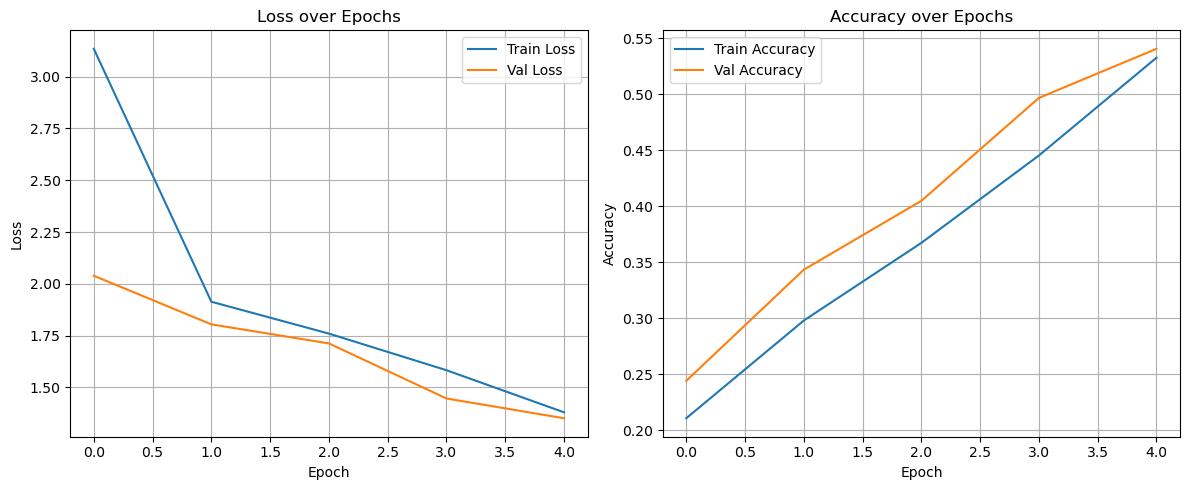

In [ ]:
# TODO: 5. Plot the loss and accuracy curves.

# Plotting Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses_resnet34, label='Train Loss')
plt.plot(val_losses_resnet34, label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs_resnet34, label='Train Accuracy')
plt.plot(val_accs_resnet34, label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Step 3 Train the student model (ResNet18)
1. Set hyperparameters for the distillation process.
2. Create a NON-PRETRAINED ResNet18 and move the model to selected device.
3. Load the saved ResNet34 and move the model to selected device.
4. Define the optimizer, loss function, etc.
5. Train ResNet18 and save the best-performing parameters to 'resnet18_checkpoint.pkl'.
6. Plot the loss and accuracy curves.

In [ ]:
# Verify data shapes

num_classes = max(labels_train_index) + 1
print(num_classes)
print(tensor_train.shape)
print(tensor_val.shape)
print(tensor_test.shape)
print(labels_train_index.shape)
print(labels_val_index.shape)

tensor(10)
torch.Size([7800, 3, 224, 224])
torch.Size([2600, 3, 224, 224])
torch.Size([2600, 3, 224, 224])
torch.Size([7800])
torch.Size([2600])


In [ ]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126

In [ ]:
import torch
print(torch.version.cuda)         # Should not be None
print(torch.cuda.is_available())  # Should be True
print(torch.cuda.device_count())  # Should be >= 1


12.6
True
1


In [188]:
# TODO: 1. Set hyperparameters for the distillation process.

MAX_EPOCH = 5
INIT_LR = 0.001 # good starting lr for knowledge distillation or small model with soft targets
BATCH_SIZE = 64 # small batch = better generalization but noisier results, large batch = faster training but less accurate
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

TEMPERATURE = 4.0 # controlling softness of the teacher model's output logits. Helps student model learn better generalization patterns. Higher temp = Generalized prediction, Lower temp = Confident/Sharper prediction
LOSS_RATIO = 0.7 # balance for student model to learn from teacher knowledge, and true labels. Higher values = stronger knowledge distillation effect

In [84]:
# TODO: 2. Create a NON-PRETRAINED ResNet18 and move the model to selected device.
import torchvision.models as models

resnet18 = models.resnet18(pretrained=False) # adding untrained resnet18 with original weights
resnet18.fc = nn.Linear(in_features=512, out_features=10) # make sure resnet18 has same output size as resnet34
resnet18 = resnet18.to(device) # put it onto our device, aka our gpu

x:\Anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
x:\Anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [163]:
# TODO: 3. Load the saved ResNet34 and move the model to selected device.
# Hint: Enable the evaluation mode to prevent updating the parameters.

resnet34 = models.resnet34(pretrained=False) # add in resnet34 model structure, so we can then input the contents from saved model
resnet34.fc = nn.Linear(512,10)
resnet34.load_state_dict(torch.load('../models/resnet34_checkpoint.pkl', map_location=device)) # loading saved model
                                                                                               # map_locaton=device > important if the model was trained on different devices, allowing pytorch to remap on another device
resnet34 = resnet34.to(device) 
resnet34.eval() # set to evaluation mode, so parameters will not update automatically

for param in resnet34.parameters():
    param.requires_grad = False

x:\Anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
x:\Anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [164]:
# TODO: 4. Define the optimizer, loss function, etc.

optimizer = torch.optim.Adam(resnet18.parameters(), lr=INIT_LR) # used to update model parameters. Common choice is Adam or SGD, but we've setteled with Adam due to broad general good fit on every problem
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1) # adjust lr during training to help with convergence. This is reducing lr by 0.1 every 20 epochs

In [181]:
# TODO: 5. Train ResNet18 and save the best-performing parameters to 'resnet18_checkpoint.pkl'.
# Hint: Use the correct loss function for knowledge distillation.
#       Details can be fund in https://docs.pytorch.org/tutorials/beginner/knowledge_distillation_tutorial.html.
from torch.utils.data import DataLoader # importing this, which helps implement shuffling element, and handles memory
import time
from torch.amp import autocast
from tqdm import tqdm  # Optional, for progress bar

# load all the tensors beforehand
tensor_train = tensor_train.to(device)
labels_train_index = labels_train_index.to(device)
tensor_val = tensor_val.to(device)
labels_val_index = labels_val_index.to(device)

# Wrap the dataset to also have indexes
class IndexedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, idx):
        x, y = self.dataset[idx]
        return x, y, idx

# firstly combine tensor images and labels into a dataset, for both train and val
train_dataset = torch.utils.data.TensorDataset(tensor_train, labels_train_index) # combining both tensors into a dataset
train_dataset_indexed = IndexedDataset(train_dataset)
train_loader = DataLoader(train_dataset_indexed, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

teacher_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# combine for validation set
val_dataset = torch.utils.data.TensorDataset(tensor_val, labels_val_index)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

train_accs_resnet18, train_losses_resnet18, val_accs_resnet18, val_losses_resnet18 = [], [], [], []

loss_fn_hard = nn.CrossEntropyLoss() # used to compare student output prediction with the true class labels
loss_fn_soft = nn.KLDivLoss(reduction='batchmean') # measures how well the student's soft probabilities are to the teacher's soft probabilities, aka mimicking

soft_teacher = []

with torch.no_grad(), torch.amp.autocast("cuda"):
    for inputs, _, _ in tqdm(train_loader):
        inputs = inputs.to(device)
        outputs = resnet34(inputs)
        soft_targets = F.softmax(outputs / TEMPERATURE, dim=1)
        soft_teacher.append(soft_targets.cpu())

# After collecting all batches, concatenate into one tensor
soft_teacher = torch.cat(soft_teacher, dim=0)
soft_teacher = soft_teacher.to(device)


for inputs, labels, indices in train_loader:
    indices = indices.long().to('cpu')  # indexing on CPU
    soft_teacher_batch = soft_teacher[indices].to(device)

torch.save(soft_teacher, '../data_preprocessed/teacher_soft_targets.pt')
print('Teacher outputs precomputed and saved :)')


100%|██████████| 122/122 [03:03<00:00,  1.50s/it]


Teacher outputs precomputed and saved :)


In [185]:
print(f"indices type: {type(indices)}, dtype: {getattr(indices, 'dtype', None)}, shape: {getattr(indices, 'shape', None)}")
print(f"indices content: {indices}")


indices type: <class 'torch.Tensor'>, dtype: torch.int64, shape: torch.Size([56])
indices content: tensor([3650, 1073, 6751, 3288, 2131,  660, 3924,  571, 3599, 6691, 2686, 6898,
        6626, 3930, 2485,  742, 3832, 7016, 1388,  570,  491, 7068, 6290, 7613,
         486, 2612, 6650, 1218, 4360, 4793, 6822, 7701, 3095, 5134, 1801, 6208,
        5490, 1150, 4483, 3997, 6207, 7751, 3149, 2991, 5783,  343, 5557, 7047,
         645, 7421, 4329, 5148, 4506,   41, 3847, 2634])


In [186]:
print(f"soft_teacher type: {type(soft_teacher)}")
print(f"soft_teacher shape: {soft_teacher.shape if isinstance(soft_teacher, torch.Tensor) else 'N/A'}")


soft_teacher type: <class 'torch.Tensor'>
soft_teacher shape: torch.Size([7800, 10])


In [145]:
train_loader

In [141]:
soft_teacher = torch.load('../data_preprocessed/teacher_soft_targets.pt')

In [143]:
soft_teacher


tensor([[0.0849, 0.1737, 0.0812,  ..., 0.0745, 0.1206, 0.0684],
        [0.1381, 0.0499, 0.1019,  ..., 0.1667, 0.0884, 0.1197],
        [0.1142, 0.0802, 0.0809,  ..., 0.1007, 0.1248, 0.1176],
        ...,
        [0.1293, 0.0501, 0.1205,  ..., 0.0687, 0.1223, 0.1358],
        [0.0587, 0.0687, 0.0987,  ..., 0.1145, 0.1991, 0.0866],
        [0.0931, 0.0529, 0.1589,  ..., 0.0666, 0.1053, 0.1061]])

In [196]:
start = time.time()

resnet18.train()

for epoch in range(MAX_EPOCH):
    print(f'\nEPOCH: {epoch + 1}/{MAX_EPOCH}') # stating which epoch we're at, out of the number of epochs we're training the model

    # Create variables to hold accuracy and loss data during training
    train_correct = 0 # how many predictions were correct
    train_total = 0 # how many samples the model has seen
    train_loss = 0.0 # accumulation of total loss from every batch

    for inputs, labels, indices in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        indices = indices.long().to('cpu')
        soft_teacher_batch = soft_teacher[indices].to(device)

        with autocast('cuda'):
            student_outputs = resnet18(inputs)

        soft_student = torch.log_softmax(student_outputs / TEMPERATURE, dim=1) # log_softmax > converting logits into log-probabilities, aka our model outputs. As KLDivLoss expects it from our student model, over teacher model
                                                                           # student_outputs/TEMPERATURE > dividing outputs with temp softens probability 
        
        loss_soft = loss_fn_soft(soft_student, soft_teacher_batch) * (TEMPERATURE ** 2) # bringing softened student logits, and teacher softened logits, then comparing the two with loss_fn_soft, aka KLDivLoss
                                                                                  # temp^2 > is done to return the logits back to original scale. Even though its '/temp', its divided again due to both becoming derivative
        loss_hard = loss_fn_hard(student_outputs, labels)
        loss = LOSS_RATIO * loss_soft + (1 - LOSS_RATIO) * loss_hard

        optimizer.zero_grad()
        loss.backward() # performs backpropagation, by using the loss values, and computing how much the parameter should change to fix the mistake, aka it's gradient
        torch.nn.utils.clip_grad_norm_(resnet18.parameters(), max_norm=1.0)  # Prevent exploding gradients
        optimizer.step() # updating the model weights for the specific batch it's learnt from

        train_loss += loss.item() * inputs.size(0) # computing total loss per batch. Where (loss value * batch size). Helps sum total loss for every batch, no matter the batch size
        _, predicted = torch.max(student_outputs,1) # we pull the output (prediction probabilities), and have pytorch pull out the max/highest probability
                                            # '_' > the highest prediction value, 'predicted' > index location of prediction value. The value of prediction is not important, but rather the indexing, as that's the class label
        train_correct += (predicted == labels).sum().item() # collect all the number of times, prediction is correct. '.item()' > converts tensor element into an integer, so mathematical operations wouldn't cause errors
        train_total += labels.size(0) # counting the total number of training data we have. labels.size(0) gives us the batch size, and we add it on top every round

    scheduler.step() # the learning rate will update based on scheduler. It's outside the loop as it only operates by epoch, not batch like optimizer

    train_loss = train_loss/train_total # get average loss, by dividing the total loss with the number of training data
    train_acc = train_correct/train_total # dividing the correct predictions, over total number of predictions, give us a value of how accurate the modelis
    train_losses_resnet18.append(train_loss) # append our results for one epoch
    train_accs_resnet18.append(train_acc)

    # Validation
    resnet18.eval() # change to evaluation mode to prevent updating of gradients
    val_correct = 0
    val_total = 0
    val_loss = 0.0

    with torch.no_grad(): # gradient tracking is disabled, since we're in validation state. No need to train the model
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            student_outputs = resnet18(inputs)
            loss = loss_fn_hard(student_outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(student_outputs,1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

        val_loss = val_loss/val_total
        val_acc = val_correct/val_total
        val_losses_resnet18.append(val_loss)
        val_accs_resnet18.append(val_acc)

        print(f'Epoch {epoch+1} > Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.3f}, Val Loss: {val_loss:.3f}, Val Acc: {val_acc:.3f}')


EPOCH: 1/5


100%|██████████| 122/122 [13:03<00:00,  6.42s/it]


Epoch 1 > Train Loss: nan, Train Acc: 0.100, Val Loss: nan, Val Acc: 0.100

EPOCH: 2/5


100%|██████████| 122/122 [06:44<00:00,  3.31s/it]


Epoch 2 > Train Loss: nan, Train Acc: 0.100, Val Loss: nan, Val Acc: 0.100

EPOCH: 3/5


100%|██████████| 122/122 [05:53<00:00,  2.90s/it]


Epoch 3 > Train Loss: nan, Train Acc: 0.100, Val Loss: nan, Val Acc: 0.100

EPOCH: 4/5


100%|██████████| 122/122 [06:10<00:00,  3.04s/it]


Epoch 4 > Train Loss: nan, Train Acc: 0.100, Val Loss: nan, Val Acc: 0.100

EPOCH: 5/5


100%|██████████| 122/122 [08:52<00:00,  4.37s/it]


Epoch 5 > Train Loss: nan, Train Acc: 0.100, Val Loss: nan, Val Acc: 0.100


## Debugging KD model:

Currently I have the issue where the resnet18 student model is not working the way I wanted. Not only were displays of accuracy and loss were unchanged, but for some reason it kept predicting `sunglasses` over and over again. Doesn't seem like an error in value predicting, since it's specifically chosen index `8` over something like `0`.

Another thing that's been a big struggling, is figuring out why the teacher pass and backpropagation takes an exorbitant amount of time, that it feels absurd to even do 1 epoch of training through KD.

In [197]:
resnet34(inputs)

tensor([[-3.1311e+00, -2.9836e+00,  3.0005e-01,  1.9641e+00, -2.8917e-01,
         -6.3114e-01, -6.5809e-01,  2.5200e+00,  3.1152e+00, -4.2060e-01],
        [-2.2463e+00, -4.1348e+00,  4.6480e-01,  1.7709e+00, -8.5338e-01,
         -9.7375e-01, -1.5581e+00,  2.1753e+00,  4.2128e+00,  8.9416e-01],
        [-5.2547e-01, -4.2132e+00,  1.0692e+00, -1.3075e+00,  1.9956e+00,
          3.4052e-01, -2.4775e+00,  4.2743e-01,  2.5332e+00,  2.0372e+00],
        [-7.7499e-01, -1.9525e+00,  8.6060e-01,  5.2349e-01,  4.9581e-01,
         -6.4945e-01, -1.2818e+00,  1.7167e+00,  5.3201e-01,  3.2251e-01],
        [-2.2569e+00, -3.2042e+00,  1.2383e-01,  1.5722e+00, -8.2378e-01,
         -1.4310e+00, -8.2346e-01,  2.7829e+00,  3.7487e+00,  9.0035e-02],
        [ 6.2490e-01,  5.9790e+00, -1.6836e+00,  2.2090e+00, -2.5608e+00,
         -2.9473e+00,  2.7173e+00, -2.7038e+00,  5.4783e-01, -2.1189e+00],
        [-1.6112e+00,  1.0583e-01,  1.0166e-01,  3.4740e+00, -1.0924e+00,
         -1.0644e+00, -2.2110e-0

In [199]:
print(torch.argmax(teacher_outputs, dim=1))  # Are all the labels the same?


tensor([2, 4, 4, 4, 8, 7, 8, 7, 4, 4, 8, 8, 8, 3, 4, 4, 4, 9, 7, 0, 7, 8, 4, 2,
        8, 4, 0, 8, 4, 6, 8, 8, 4, 7, 8, 8, 4, 3, 8, 4, 6, 8, 8, 4, 4, 9, 8, 8,
        4, 8, 8, 8, 4, 8, 7, 9], device='cuda:0')


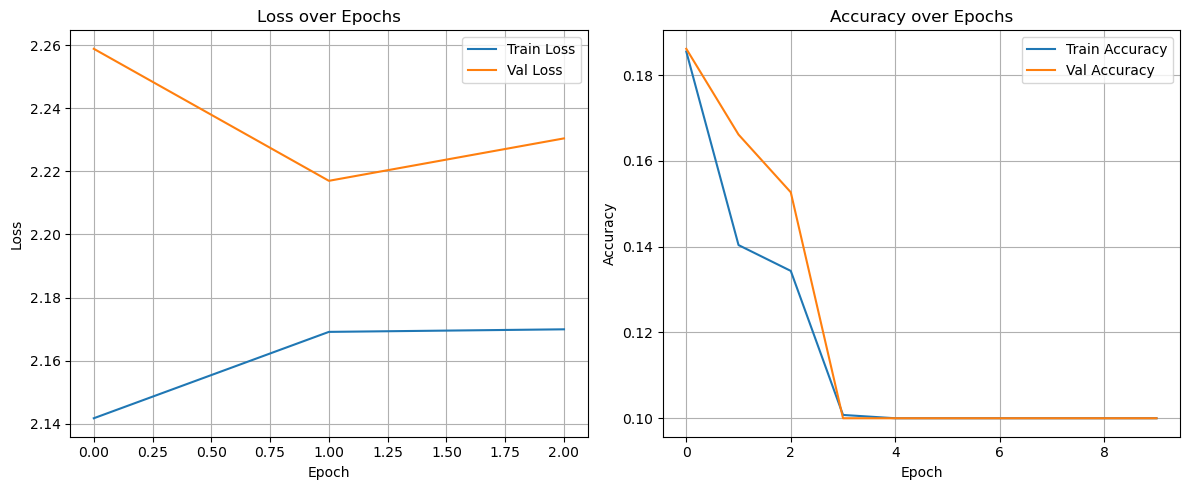

In [200]:
# TODO: 6. Plot the loss and accuracy curves.

# Plotting Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses_resnet18, label='Train Loss')
plt.plot(val_losses_resnet18, label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs_resnet18, label='Train Accuracy')
plt.plot(val_accs_resnet18, label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [201]:
torch.save(resnet18.state_dict(), '../models/resnet18_checkpoint.pkl')

# Step 4 Predict labels in the testing set
1. Load the saved ResNet18 and move it to the selected device.
2. Do prediction using the images in the testing set.
3. Write the results into the CSV file for submission.

In [202]:
# TODO: 1. Load the saved ResNet18 and move it to the selected device.
# Hint: Enable the evaluation mode to prevent updating the parameters.

resnet18 = models.resnet18(pretrained=False)
resnet18.fc = nn.Linear(512, 10)  # adjust output layer
resnet18.load_state_dict(torch.load('../models/resnet18_checkpoint.pkl', map_location=device))
resnet18 = resnet18.to(device)
resnet18.eval()



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [203]:
# TODO: 2. Do prediction using the images in the testing set.
predictions = []

with torch.no_grad():
    for inputs in tensor_test:
        inputs = inputs.unsqueeze(0).to(device)
        outputs = resnet18(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())


In [204]:
# TODO: 3. Write the results into the CSV file for submission.
# Hint: The CSV file should be in the format of 'file_name' and 'label'.
#       The submission.csv should look like:
#           file_name,label
#           0.jpg,sunglasses
#           ...

index_to_label = {v: k for k, v in label_to_index.items()}

import csv

# If predictions is a torch tensor, convert it to list
if isinstance(predictions, torch.Tensor):
    predictions = predictions.tolist()

# Create the submission file
with open('submission.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['file_name', 'label'])  # Write the header

    for i, pred_idx in enumerate(predictions):
        filename = f"{i}.jpg"
        label = index_to_label[pred_idx]
        writer.writerow([filename, label])